In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
!pip install category-encoders

In [ ]:
!pip install lightgbm

In [ ]:
!pip install catboost

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer  
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import category_encoders as ce
from sklearn.preprocessing import QuantileTransformer,RobustScaler,StandardScaler
from sklearn.linear_model import ElasticNet,LinearRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.pipeline import Pipeline
import lightgbm as lgbm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA,KernelPCA
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from h2o.estimators import H2OXGBoostEstimator
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor,RandomForestRegressor

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.callbacks import EarlyStopping

In [ ]:
import h2o
h2o.init()

### Getting the data

In [ ]:
train_df=h2o.import_file('/kaggle/input/tabular-playground-series-feb-2021/train.csv')
test_df=h2o.import_file('/kaggle/input/tabular-playground-series-feb-2021/test.csv')

In [ ]:
train_df.shape

In [ ]:
train_df.describe()

### Missing Values

There are no missing values in both train and test.

In [ ]:
train_df.as_data_frame().isnull().sum()

In [ ]:
test_df.as_data_frame().isnull().sum()

### Outliers

In [ ]:
train_df.as_data_frame().skew()

In [ ]:
fig=go.Figure()

fig.add_trace(go.Histogram(x=train_df.as_data_frame()['target'],name='Train'))
fig.show()

Target has a left tail distribution. Transforming the target variable might help.

In [ ]:
"""
train_num=train_df.as_data_frame().select_dtypes(exclude='object')

train_num=train_num[train_num.columns[1:-1]]

fig=make_subplots(rows=7,cols=2,subplot_titles=(train_num.columns))
index=0

for i in range(1,8):
    for j in range(1,3):
        train_data=train_df.as_data_frame()[train_num.columns[index]]
        test_data=test_df.as_data_frame()[train_num.columns[index]]
        fig.add_trace(go.Histogram(x=train_data),row=i,col=j)
        fig.add_trace(go.Histogram(x=test_data),row=i,col=j)
        # Overlay both histograms
        fig.update_layout(barmode='overlay')
        # Reduce opacity to see both histograms
        fig.update_traces(opacity=0.75)
        index+=1
        
fig.update_layout(height=900,width=1250,title_text="Distribution of Training and Testing Data")
fig.show("notebook")
"""

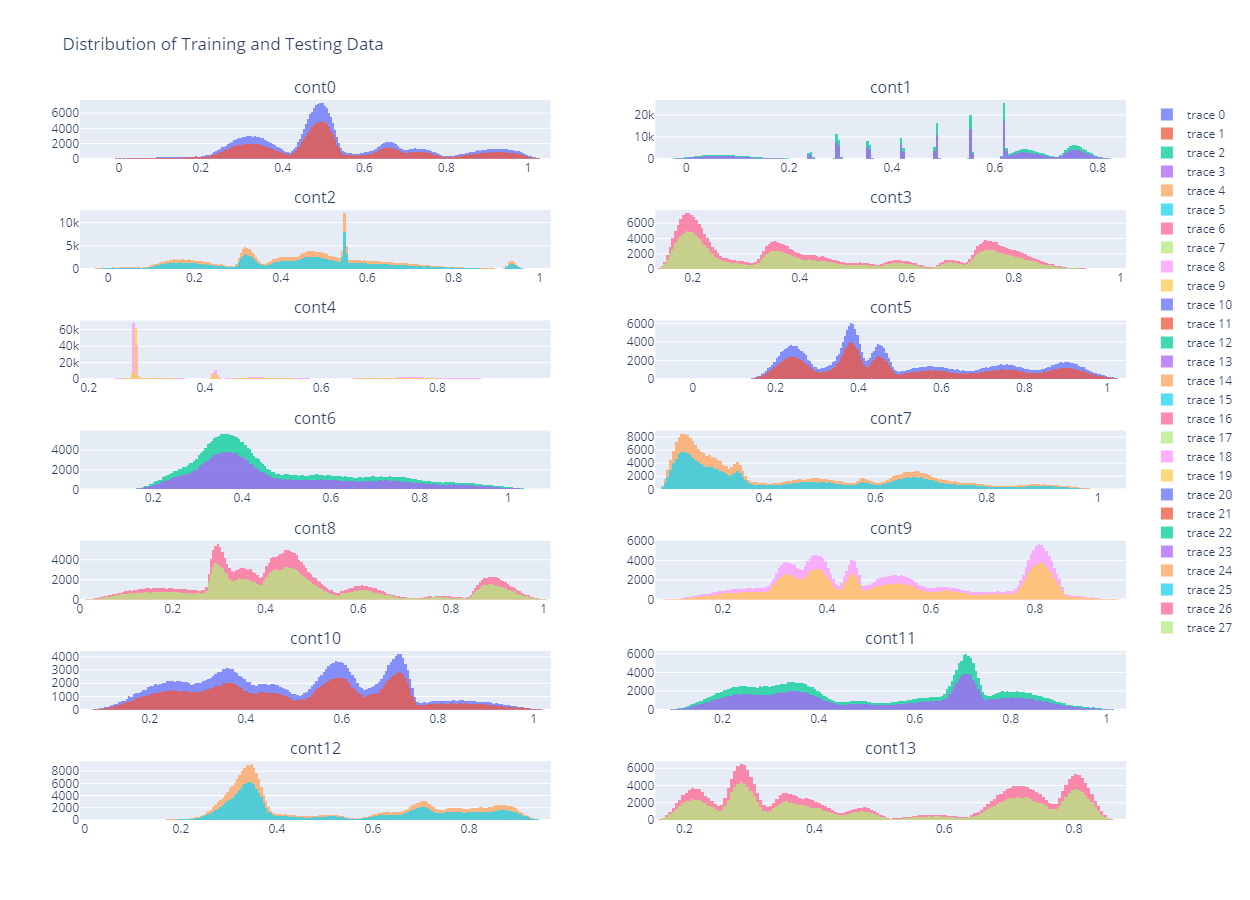

I have commented the above code block as it takes up a lot of memory but I have attached the output graph as png in this cell.

1. All features have different scales - Scaling is needed esp for linear and NN
2. All the features have different distribution and none of them follow normal distrubtion
3. Training and Testing distributions match for each feature

In [ ]:
train_df.as_data_frame().select_dtypes(include='object').shape

In [ ]:
train_df.as_data_frame().select_dtypes(include='object').columns

In [ ]:
"""
train_cat=train_df.as_data_frame().select_dtypes(include='object')

fig=make_subplots(rows=5,cols=2,subplot_titles=(train_cat.columns))
index=0

for i in range(1,6):
    for j in range(1,3):
        train_data=train_df.as_data_frame()[train_cat.columns[index]]
        test_data=test_df.as_data_frame()[train_cat.columns[index]]
        fig.add_trace(go.Histogram(x=train_data),row=i,col=j)
        fig.add_trace(go.Histogram(x=test_data),row=i,col=j)
        # Overlay both histograms
        fig.update_layout(barmode='group')
        index+=1
        
fig.update_layout(height=900,width=1250,title_text="Distribution of Categorical Training and Testing Data")
fig.show("notebook")
"""


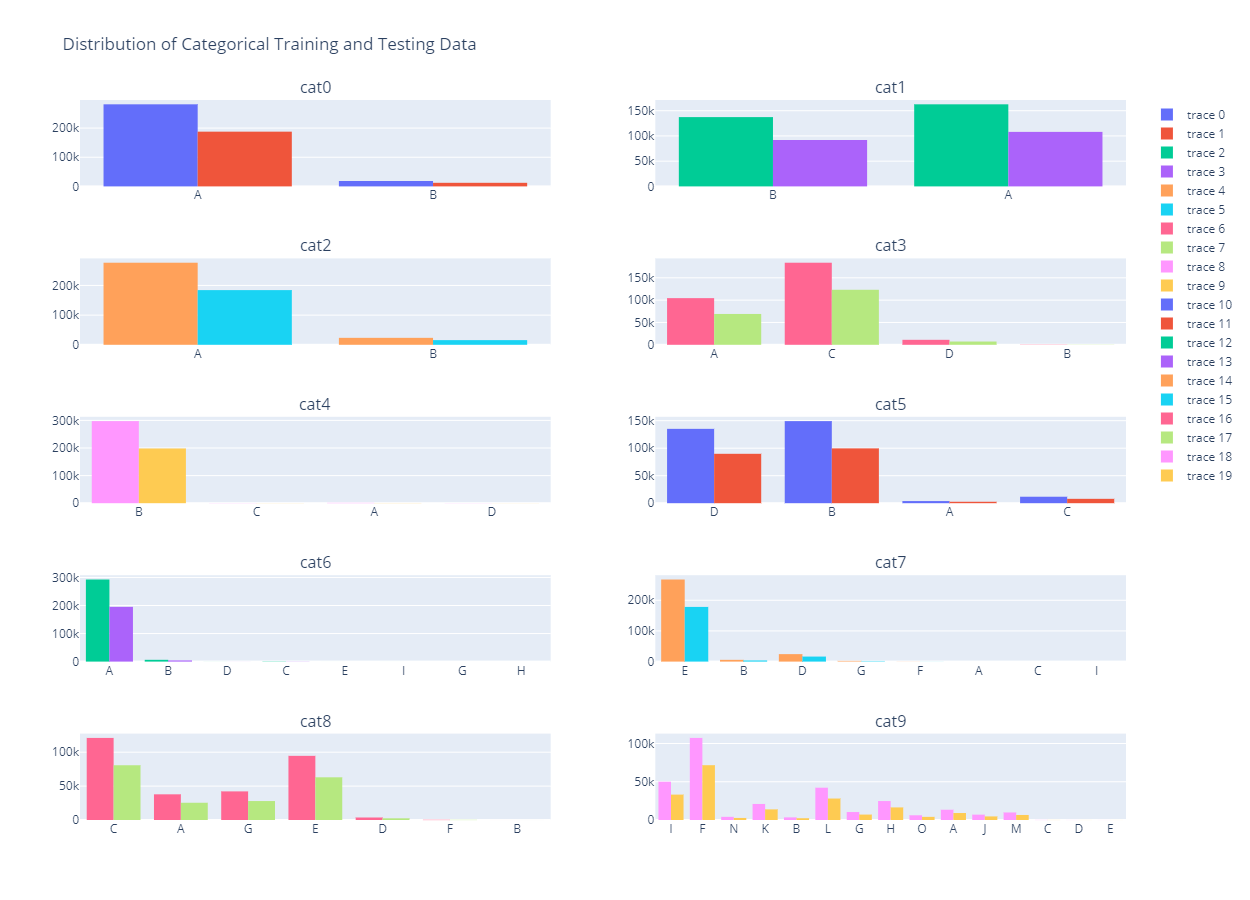

### Elasticnet Pipeline

1. Catboost encoder
2. Quantile Transformation
3. Robust Scaling 
4. Elastic Net Regression

In [ ]:
X=train_df[train_df.columns[1:-1]].as_data_frame()
y=train_df[train_df.columns[-1]].as_data_frame()

In [ ]:
cat_encoder=ce.CatBoostEncoder(cols=list(train_df.as_data_frame().select_dtypes(include='object').columns))
qt=QuantileTransformer(output_distribution='normal')
rs=RobustScaler()
en=ElasticNet(random_state=123)
poly=PolynomialFeatures(include_bias=False,degree=2)
pca=PCA(n_components=0.99)

Adding polynomial features did not improve the performance

In [ ]:
en_pipeline=Pipeline([('Cat_Encoder',cat_encoder),
                  ('Quantile transformer',qt),
                  ('Scaling',rs),
                  ('Elastic Net',en)])

In [ ]:
en_scores=cross_val_score(en_pipeline,X,y,cv=3,scoring='neg_mean_squared_error')

In [ ]:
np.mean(np.sqrt(-en_scores))

Let's check the assumptions of linear regssion are met or not.

In [ ]:
y_pred=cross_val_predict(en_pipeline,X,y,cv=3)

In [ ]:
en_pipeline.fit(X,y)
y_pred=en_pipeline.predict(X)

In [ ]:
#Below plot is not a straight line
#px.scatter(x=np.ravel(y.values),y=y_pred) 

In [ ]:
preprocess_pipe=Pipeline([('Cat_Encoder',cat_encoder),
                  ('Quantile transformer',qt),
                  ('Scaling',rs)])

In [ ]:
X_preprocessed=preprocess_pipe.fit_transform(X,y)

In [ ]:
X_preprocessed_df=pd.DataFrame(X_preprocessed,columns=X.columns)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=[variance_inflation_factor(X_preprocessed_df.values,i) for i in range(X_preprocessed_df.shape[1])]

In [ ]:
vif

No multicollinearity present but since there is no linearity present we cannot use Linear models.

### LightGBM Pipeline

LGBM can handle categorical features by changing the data types pf these features to "category: however it is mentioned in the [documentation](http://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html) that for high cardinality datasets it is better to convert the categorical data as numeric

0.86007457730236 as rmse with pca and 0.8589879204686376 as rmse with hyperparametertuning. 

In [ ]:
lgb_reg =lgbm.LGBMRegressor(random_state=123)
lgbm_pipeline=Pipeline([('Cat_Encoder',cat_encoder),
                        ('pca',pca),
                  ('lgbm',lgb_reg)])

In [ ]:
#lgbm_scores=cross_val_score(lgbm_pipeline,X,np.ravel(y),cv=3,scoring='neg_mean_squared_error')

In [ ]:
#np.mean(np.sqrt(-lgbm_scores))

In [ ]:
"""
param_test ={'lgbm__n_estimators':[1000,1500,2000,2500,3000,3500,4000],
             'lgbm__max_depth':[1,2,3,4,5,6,7,8],
             'lgbm__l2_leaf_reg': np.arange(2, 30,1)}

tuned_lgbm=BayesSearchCV(lgbm_pipeline,param_test,cv=3,scoring='neg_mean_squared_error',random_state=123)
tuned_lgbm.fit(X,np.ravel(y))
"""

In [ ]:
#np.sqrt(-tuned_lgbm.best_score_) 

In [ ]:
#tuned_lgbm.best_params_

In [ ]:
lgb_reg =lgbm.LGBMRegressor(random_state=123,l2_leaf_reg=20,max_depth=3,n_estimators=1000)
lgbm_pipeline=Pipeline([('Cat_Encoder',cat_encoder),
                        ('pca',pca),
                  ('lgbm',lgb_reg)])

In [ ]:
lgbm_scores=cross_val_score(lgbm_pipeline,X,np.ravel(y),cv=3,scoring='neg_mean_squared_error')

In [ ]:
np.mean(np.sqrt(-lgbm_scores))

In [ ]:
lgbm_pipeline.fit(X,np.ravel(y))

### Catboost Pipeline

0.8446898153043176 as rmse with just catboost.

In [ ]:

cat =CatBoostRegressor(random_state=123,cat_features=list(train_df.as_data_frame().select_dtypes(include='object').columns))

cat_pipeline=Pipeline([('catboost',cat)])

In [ ]:
#cat_scores=cross_val_score(cat_pipeline,X,np.ravel(y),cv=3,scoring='neg_mean_squared_error')

In [ ]:
#np.mean(np.sqrt(-cat_scores))

In [ ]:
"""
search_spaces = {'catboost__iterations': [1000,1500,2000,2500,3000,3500,4000],
                 'catboost__depth': Integer(1, 8),
                 #'catboost__learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 #'catboost__random_strength': Real(1e-9, 10, 'log-uniform'),
                 #'catboost__bagging_temperature': Real(0.0, 1.0),
                 #'catboost__border_count': Integer(1, 255),
                 'catboost__l2_leaf_reg': Integer(2, 40)}
"""                 

In [ ]:
"""
tuned_cat=BayesSearchCV(cat_pipeline,search_spaces,cv=3,scoring='neg_mean_squared_error',random_state=123)
tuned_cat.fit(X,np.ravel(y))
"""

In [ ]:

cat =CatBoostRegressor(random_state=123,
                       iterations=3000,
                       l2_leaf_reg=10,
                       cat_features=list(train_df.as_data_frame().select_dtypes(include='object').columns))

cat_pipeline=Pipeline([('catboost',cat)])             


In [ ]:
cat_scores=cross_val_score(cat_pipeline,X,np.ravel(y),cv=3,scoring='neg_mean_squared_error')

In [ ]:
np.mean(np.sqrt(-cat_scores)) 

In [ ]:
cat_pipeline.fit(X,np.ravel(y)) 

### Ensemble

In [ ]:
y_lgbm=lgbm_pipeline.predict(X)
y_cat=cat_pipeline.predict(X)

In [ ]:
en_df=pd.DataFrame()
en_df['LGBM']=y_lgbm
en_df['CAT']=y_cat
en=ElasticNet(random_state=123)
poly=PolynomialFeatures(include_bias=False,degree=2)

In [ ]:
ensemble_pipe=Pipeline([('poly_features',poly),('linear reg',en)])

In [ ]:
ensemble_scores=cross_val_score(ensemble_pipe,en_df,np.ravel(y),scoring='neg_mean_squared_error',cv=3)  

In [ ]:
np.sqrt(-ensemble_scores.mean())

In [ ]:
ensemble_pipe.fit(en_df,np.ravel(y))

In [ ]:
#estimators=[('lgbm', lgbm_pipeline),('catboost',cat_pipeline)]

In [ ]:
"""
reg = StackingRegressor(estimators=estimators,
                        final_estimator=lgbm.LGBMRegressor(random_state=123))
"""                        

In [ ]:
#ensemble_scores=cross_val_score(reg,X,np.ravel(y),scoring='neg_mean_squared_error',cv=3)  

In [ ]:
#np.sqrt(-ensemble_scores.mean()) #0.8439311919873552 with LGBM as final estimator

In [ ]:
#reg.fit(X,np.ravel(y)) 

In [ ]:
"""  
ann = Sequential()
ann.add(BatchNormalization())
ann.add(Dense(units=50,activation='selu',kernel_initializer='lecun_normal',input_dim=NN_in.shape[1]))
ann.add(Dropout(0.3,seed=0))
ann.add(BatchNormalization())
ann.add(Dense(units=100,activation='selu',kernel_initializer='lecun_normal'))
ann.add(Dropout(0.3,seed=0))
ann.add(BatchNormalization())
ann.add(Dense(units=50,activation='selu',kernel_initializer='lecun_normal'))
ann.add(Dropout(0.3,seed=0))
ann.add(BatchNormalization())
ann.add(Dense(units=1,activation='sigmoid',kernel_initializer='glorot_uniform'))
"""

In [ ]:
"""
ann.compile(optimizer='adam',loss='mean_squared_error')

#early stopping to avoid overfitting

es=EarlyStopping(monitor='val_mean_squared_error',patience=20,mode='min')

model_history=ann.fit(NN_in,np.ravel(y),epochs=50,validation_split=0.1,callbacks=[es],batch_size=100)
"""

In [ ]:
"""
fig=go.Figure()

fig.add_trace(go.Scatter(x=[i for i in range(0,101)],y=model_history.history['loss'],mode='lines',name='Training Error'))
fig.add_trace(go.Scatter(x=[i for i in range(0,101)],y=model_history.history['val_loss'],mode='lines',name='Validation Error'))
fig.show()
"""

### Test Data

In [ ]:
test_df.head()  

In [ ]:
X_test=test_df[test_df.columns[1:]].as_data_frame()

In [ ]:

y_lgbm=lgbm_pipeline.predict(X_test)
y_cat=cat_pipeline.predict(X_test)


In [ ]:
en_df=pd.DataFrame()
en_df['LGBM']=y_lgbm
en_df['CAT']=y_cat

In [ ]:
en_df.shape

In [ ]:
len(y_lgbm),len(y_cat)

In [ ]:
y_ensemble=ensemble_pipe.predict(en_df)

In [ ]:
sub_df=pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv')

In [ ]:
sub_df.head()

In [ ]:
sub_df.shape

In [ ]:
#sub_df['target']= y_cat

In [ ]:
sub_df['target']= (0.7*y_cat)+(0.3*y_lgbm)

In [ ]:
sub_df.to_csv('submission.csv', index=False)

In [ ]:
sub_df1=sub_df.copy()
sub_df1['target']= (0.8*y_cat)+(0.2*y_lgbm)
sub_df2=sub_df.copy()
sub_df2['target']= (0.6*y_cat)+(0.2*y_lgbm)+(0.2*y_ensemble)
sub_df3=sub_df.copy()
sub_df3['target']= (0.7*y_cat)+(0.2*y_lgbm)+(0.1*y_ensemble)
sub_df4=sub_df.copy()
sub_df4['target']= (0.7*y_cat)+(0.1*y_lgbm)+(0.2*y_ensemble)

In [ ]:
sub_df1.to_csv('submission_df1.csv', index=False)
sub_df2.to_csv('submission_df2.csv', index=False)
sub_df3.to_csv('submission_df3.csv', index=False)
sub_df4.to_csv('submission_df4.csv', index=False)

In [ ]:
sub_df.head()